In [1]:
import torch # 导入pytorch
from torch import nn, optim # 导入神经网络与优化器对应的类
import torch.nn.functional as F
from torchvision import datasets, transforms ## 导入数据集与数据预处理的方法
import torchvision

In [2]:
# 超参数
batch_size = 256
# 数据预处理
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])
data_dir = '/content/drive/MyDrive/Colab Notebooks/AlexNet'
# 加载Fashion-MNIST数据集
train_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class BasicBlock(nn.Module):

    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    # 构建多层残差块
    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
import tqdm

num_epochs = 10
learning_rate = 0.001
# 创建ResNet模型
model = ResNet(BasicBlock, [2, 2, 2, 2]) #[2, 2, 2, 2]残差块层列表
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# 将模型转移到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 训练模型
def model_train():
    total_step = len(train_loader)
    train_losses = []
    train_accs = []
    for epoch in range(num_epochs):
        losses = []
        corrects = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                losses.append(loss.item())
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        train_losses.append(sum(losses) / len(losses))
        # 在测试集上评估模型
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print('测试集准确率: {}%'.format(100 * correct / total))
            train_accs.append(100 * correct / total)
    return train_losses, train_accs


In [6]:
%time train_losses, train_accs = model_train()

Epoch [1/10], Step [100/235], Loss: 0.3222
Epoch [1/10], Step [200/235], Loss: 0.2887
测试集准确率: 88.0%
Epoch [2/10], Step [100/235], Loss: 0.2184
Epoch [2/10], Step [200/235], Loss: 0.2677
测试集准确率: 90.42%
Epoch [3/10], Step [100/235], Loss: 0.2628
Epoch [3/10], Step [200/235], Loss: 0.1674
测试集准确率: 90.77%
Epoch [4/10], Step [100/235], Loss: 0.1593
Epoch [4/10], Step [200/235], Loss: 0.2426
测试集准确率: 91.14%
Epoch [5/10], Step [100/235], Loss: 0.2332
Epoch [5/10], Step [200/235], Loss: 0.1426
测试集准确率: 91.23%
Epoch [6/10], Step [100/235], Loss: 0.1314
Epoch [6/10], Step [200/235], Loss: 0.0829
测试集准确率: 91.85%
Epoch [7/10], Step [100/235], Loss: 0.0976
Epoch [7/10], Step [200/235], Loss: 0.1702
测试集准确率: 92.05%
Epoch [8/10], Step [100/235], Loss: 0.0858
Epoch [8/10], Step [200/235], Loss: 0.1473
测试集准确率: 92.17%
Epoch [9/10], Step [100/235], Loss: 0.0737
Epoch [9/10], Step [200/235], Loss: 0.1159
测试集准确率: 91.22%
Epoch [10/10], Step [100/235], Loss: 0.1015
Epoch [10/10], Step [200/235], Loss: 0.1082
测试集准

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

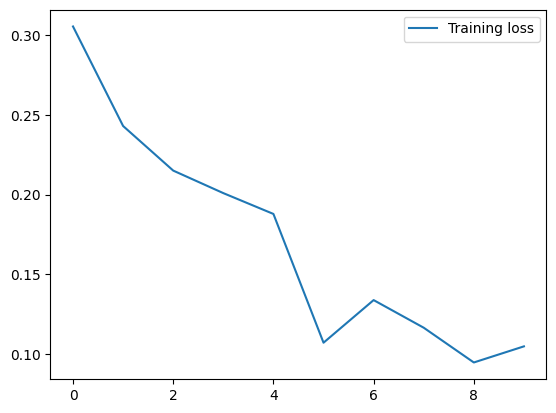

In [8]:

plt.plot(train_losses, label='Training loss')
plt.legend()


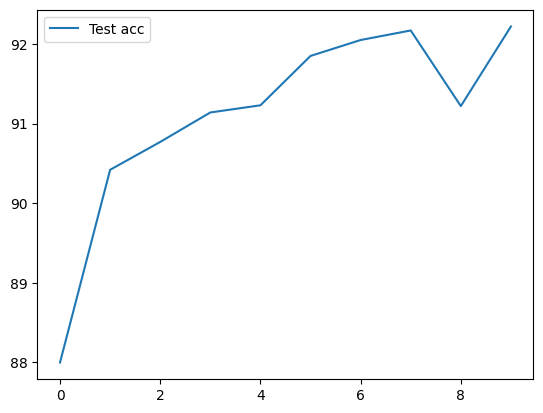

In [9]:
plt.plot(train_accs, label='Test acc')
plt.legend()